# Uso de modelos para traducción
## Machine Translation



En este notebook vamos a usar diversos modelos para la traducción automática entre idiomas

In [109]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


In [110]:
import torch
device_setup = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device_setup)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using:  cpu


Para simplificar el uso de los distintos modelos, vamos a definir una clase abstracta que implementaremos con los distintos modelos que veamos:

In [111]:
from abc import ABC, abstractmethod

class AbstractMT(ABC):

    @abstractmethod
    def translate(self, text, do_sample=True, temperature=0.1):
        pass


    def translate_batch(self, texts, do_sample=True, temperature=0.1):
        return [self.translate(text, do_sample=do_sample, temperature=temperature) for text in texts]


## Modelos entrenados inglés-español

En [Hugging Face](https://huggingface.co/models) existen multiples modelos, entre los cuales, modelos orientados a machine translation. Entre los más utilizados encontramos:

* MarianMT: es un modelo especializado para traducción automática, para nuestro problema vamos a usar la versión preentrenada para inglés a español `Helsinki-NLP/opus-mt-en-es`.
* T5: es un modelo versátil preentrenado para varias tareas, incluyendo traducción. Para nuestro problema vamos a utilizar la versión más ligera `t5-small`.

### Modelo MarianMT


Para cargar un modelo MarianMt utilizaremos el método estático de la clase con el mismo nombre `MarianMTModel.from_pretrained` indicando el nombre del modelo, que en este caso es [Helsinki-NLP/opus-mt-en-es](https://huggingface.co/Helsinki-NLP/opus-mt-en-es) y los parámetro `cache_dir` y `local_files_only` que sirven para que la primera vez se descargue el modelo y las posteriores ejecuciones se hagan usando el modelo descargado en lugar de volver a descargarlo  en cada ejecución.

In [112]:
from transformers import MarianTokenizer, MarianMTModel

def load_pretrained_marian_mt():
    global device_setup
    marian_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es", cache_dir="./models/pretrained_marian_en-es", local_files_only=False).to(device_setup)
    marian_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es", cache_dir="./models/pretrained_marian_en-es", local_files_only=False)
    return marian_model, marian_tokenizer

marian_model, marian_tokenizer = load_pretrained_marian_mt()

text = "On the table, there were a good number of topics"
inputs = marian_tokenizer(text, return_tensors="pt")
translated_tokens = marian_model.generate(**inputs, do_sample=False, temperature=1.0)
translated_text = marian_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
print(translated_text)

Sobre la mesa, había un buen número de temas


Notese que para utilizar el modelo, tenemos que pasar las entradas por el tokenizador y por el modelo. Para pasarla por el modelo utilizamos el método `.generate()` que posee varios parámetros interesantes:

* `do_sample` indica si el modelo debe muestrear probabilidades de las palabras posibles en cada paso, en lugar de elegir únicamente la palabra con la probabilidad más alta (modo greedy). Si valor es False (predeterminado)no se hace ningún muestreo y el modelo selecciona la palabra con la probabilidad más alta en cada paso (modo greedy o beam search). En cambio, si su valor es True se hacen muestreos según las probabilidades de las palabras posibles, lo que permite generar salidas más variadas. Es decir, utilizando `do_sample=False` se obtienen traducciones más deterministas y consistentes, en cambio, usando `do_sample=True` se obtienen resultados más creativos o variados, pero menos deterministas.
* `temperature` escala las probabilidades de las palabras generadas por el modelo, controlando la "aleatoriedad" del muestreo. Puede tomar los siguientes valores: un valor mayor a 1.0 aumenta la diversidad favoreciendo palabras menos probables; un valor menor a 1.0 reduce la diversidad, concentrándose en palabras más probables; un valor de 1.0 (predeterminado) utiliza las probabilidades originales del modelo. Por lo tanto, cuando `do_sample=False`, este parámetro no tiene efecto (porque no hay muestreo). Por el contrario, si `do_sample=True` regula la aleatoriedad en las generaciones.
* `num_beams` activa el beam search, una técnica que explora múltiples caminos en paralelo para encontrar la secuencia más probable. Puede tomar distintos valores: `num_beams=1` (predeterminado) indica un modo de operación greedy; `num_beams>1` indica el número de caminos a explorar. Este parámetro puede mejorar la calidad de las generaciones a costa de mayor tiempo de cómputo si se aumenta su valor.

Usando el código anterior, vamos a empaquetarlo en una clase hija de AbstractMT

In [113]:
class MarianMT(AbstractMT):

    def __init__(self, model_name="Helsinki-NLP/opus-mt-en-es", cache_dir="./models/opus-mt-en-es"):
        global device_setup
        self.model = MarianMTModel.from_pretrained(model_name, cache_dir=cache_dir).to(device_setup)
        self.tokenizer = MarianTokenizer.from_pretrained(model_name, cache_dir=cache_dir)


    def translate(self, text, do_sample=True, temperature=0.1):
        global device_setup
        # Tokenizar la entrada
        inputs_tokenized = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device_setup)
        # Traducir
        translated_tokens = self.model.generate(**inputs_tokenized, max_length=200, do_sample=do_sample,  temperature=temperature)
        # Decodificar salida
        return self.tokenizer.decode(translated_tokens[0], skip_special_tokens=True)


#### Tarea MTB1
Usar la clase `MarianMT` para traducir la frase  "On the table, there were a good number of topics"

In [114]:
mariam_mt = MarianMT()
text = "On the table, there were a good number of topics"

# DONE: traducir la frase e imprimirla por pantalla
translated_text = mariam_mt.translate(text)
print(translated_text)

Sobre la mesa, había un buen número de temas


#### Tarea MTB2
Usar la clase `MarianMT` para traducir el array de frases

In [115]:
texts = ["On the table, there were a good number of topics", "manners maketh the man"]

# DONE: traducir las frases e imprimirlas por pantalla
translated_text = mariam_mt.translate_batch(texts)
print(translated_text)

['Sobre la mesa, había un buen número de temas', 'los modales hacen al hombre']


#### Tarea MTB3

Cambiar los parámetros `do_sample=True` y probar `temperature` con valores como 0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0 para que el modelo haga traducciones o generaciones lo menos deterministas posible, es decir, produzca alucinaciones.

In [116]:
text = "On the table, there were a good number of topics"
# DONE: Para cada una de las temperaturas generar una traducción de la frase
temperatures = [0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0]
for temperature in temperatures:
    translated_text = mariam_mt.translate(text, temperature=temperature)
    print("Translation (t=",temperature,"): ",translated_text)

Translation (t= 0.1 ):  Sobre la mesa, había un buen número de temas
Translation (t= 0.7 ):  Sobre la mesa, había un buen número de temas
Translation (t= 0.5 ):  Sobre la mesa, había un buen número de temas
Translation (t= 1 ):  Sobre la mesa, había un buen número de temas
Translation (t= 1.5 ):  Sobre la mesa, había un buen número de temas
Translation (t= 2.0 ):  Sobre la mesa, había un buen número de temas
Translation (t= 4.0 ):  En el turno de oradores, el público había muy diversos temas a abordar
Translation (t= 8.0 ):  Una vez presentados, muchos serán temas importantes del debate de orientación entre estos países en torno, al cual también es necesario poner fin de modo preciso a las situaciones conflictivo de sus regiones nacionales. La Unión se basará a este respecto para facilitarles una evaluación de los objetivos


Repita el mismo código para la frase `manners maketh the man`

In [117]:
text = "manners maketh the man"
# DONE: Para cada una de las temperaturas generar una traducción de la frase
temperatures = [0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0]
for temperature in temperatures:
    translated_text = mariam_mt.translate(text, temperature=temperature)
    print("Translation (t=",temperature,"): ",translated_text)

Translation (t= 0.1 ):  los modales hacen al hombre
Translation (t= 0.7 ):  los modales hacen al hombre
Translation (t= 0.5 ):  los modales hacen al hombre
Translation (t= 1 ):  modales hacen al hombre
Translation (t= 1.5 ):  los modales hacen al hombre
Translation (t= 2.0 ):  los modales le hacen al hombre
Translation (t= 4.0 ):  maneras de hacer de un hombre
Translation (t= 8.0 ):  las actitudes de hacer Dios...


### Modelo T5

Para cargar un modelo T5 utilizaremos el método estático de la clase con el mismo nombre `T5ForConditionalgeneration.from_pretrained` indicando el nombre del modelo, que en este caso es [t5-small](https://huggingface.co/google-t5/t5-small) y los parámetro `cache_dir` y `local_files_only` que sirven para que la primera vez se descargue el modelo y las posteriores ejecuciones se hagan usando el modelo descargado en lugar de volver a descargarlo en cada ejecución. Además del modelo small, existen variantes más complejas y pesadas, como el [t5-base](https://huggingface.co/google-t5/t5-base) o el [t5-large](https://huggingface.co/google-t5/t5-large).

In [118]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_pretrained_t5():
    global device_setup
    # También existen t5-base o t5-large
    t5_model = T5ForConditionalGeneration.from_pretrained("vgaraujov/t5-base-translation-en-es", cache_dir="./models/pretrained_t5_en-es", local_files_only=False).to(device_setup)
    t5_tokenizer = T5Tokenizer.from_pretrained("vgaraujov/t5-base-translation-en-es", cache_dir="./models/pretrained_t5_en-es", local_files_only=False)
    return t5_model, t5_tokenizer

t5_model, t5_tokenizer = load_pretrained_t5()

text = "On the table, there were a good number of topics"
inputs = t5_tokenizer(text, return_tensors="pt")
translated_tokens = t5_model.generate(**inputs, do_sample=False, max_length=200, temperature=1.0)
translated_text = t5_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
print(translated_text)

En la mesa, hubo un buen número de temas.


#### Tarea MB4

Igual que antes, para facilitar el uso del modelo vamos a empaquetar el código anterior en una clase llamada `T5MT`. Cree dicha clase en la siguiente celda

In [119]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

class T5MT(AbstractMT):

    def __init__(self, model_name="vgaraujov/t5-base-translation-en-es", cache_dir="./models/t5-base-translation-en-es"):
        global device_setup
        self.model = T5ForConditionalGeneration.from_pretrained(model_name, cache_dir=cache_dir, local_files_only=False).to(device_setup)

        self.tokenizer = T5Tokenizer.from_pretrained(model_name, cache_dir=cache_dir, local_files_only=False)


    def translate(self, text, do_sample=True, temperature=0.1):
        global device_setup
        # Tokenizar la entrada
        inputs_tokenized = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device_setup)
        # Traducir
        translated_tokens = self.model.generate(**inputs_tokenized, max_length=200, do_sample=do_sample, temperature=temperature)
        # Decodificar salida
        return self.tokenizer.decode(translated_tokens[0], skip_special_tokens=True)


In [120]:
t5_mt = T5MT()

text = "On the table, there were a good number of topics"
translated_text = t5_mt.translate(text)
print(translated_text)

En la mesa, hubo un buen número de temas.


In [121]:
texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = t5_mt.translate_batch(texts)
print(translated_text)

['En la mesa, hubo un buen número de temas.', 'hace el modo de hacer el método.']


#### Tarea MTB5

Cambiar los parámetros `do_sample=True` y probar `temperature` con valores como 0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0 para que el modelo haga traducciones o generaciones lo menos deterministas posible, es decir, produzca alucinaciones.


In [122]:
text = "On the table, there were a good number of topics"
# DONE: Para cada una de las temperaturas generar una traducción de la frase
temperatures = [0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0]
for temperature in temperatures:
    translated_text = t5_mt.translate(text, temperature=temperature)
    print("Translation (t=",temperature,"): ",translated_text)

Translation (t= 0.1 ):  En la mesa, hubo un buen número de temas.
Translation (t= 0.7 ):  En la mesa hubo un buen número de temas.
Translation (t= 0.5 ):  En la mesa, hubo una buena cantidad de temas.
Translation (t= 1 ):  En las mesa había una buena cantidad de temas.
Translation (t= 1.5 ):  Se puede visualizar esta sección cuando haces clic aquí.
Translation (t= 2.0 ):  En el a o sobre el resultado del teta o, como máximo que se pueda, es r. n es por una cuestión: ""Cr. en oro... por ejemplo yo he puesto un gráfico a uno cuando un artista sabe: cuando usted escribe c doc y ve el archivo capo (en su forma cpu o su propio código"... de su amigo m piè el caneo por ser del color amarillo atendiero al mundo?", en efecto se han puesto algunos números con lbpp abajo).
Translation (t= 4.0 ):  Pero después fue mucho más difícil decidirlo porque es posible a largo rato encontrar clushboard con esa variable. Incluso cuando llegó finalmente me documenté sobre myShi©xil hall -, por donde es impor

Repita el mismo código para la frase `manners maketh the man`

In [123]:
text = "manners maketh the man"
# DONE: Para cada una de las temperaturas generar una traducción de la frase
temperatures =[0.1, 0.7, 0.5, 1, 1.5, 2.0, 4.0, 8.0]
for temperature in temperatures:
    translated_text = t5_mt.translate(text, temperature=temperature)
    print("Translation (t=",temperature,"): ",translated_text)

Translation (t= 0.1 ):  hace el modo de hacer el modo.
Translation (t= 0.7 ):  maneras hacen el método.
Translation (t= 0.5 ):  hace el modo de hacer el modo.
Translation (t= 1 ):  hace ese tipo de formas.
Translation (t= 1.5 ):  forma los géneros del hombre.
Translation (t= 2.0 ):  El caso es que cada vez de más razón del juicio le dio sentido a su religión que había recibido en relación no de origen religioso de su propia madre, la única parte a quien está sometido como ser humano o quien éste utiliza (consenada) por haber tenido un interés legítimo en sus hijos. Mientras tanto, la historia hablada del Islam de nuevo resulta completamente opuesta al principio del mundo a pesar de nuestra forma particular por sí presente (1937-66). El resto se halla aquí donde nos han asignado las preguntas específicas y es muy posible aplicar estos cambios de los bienes por sí sólo las respuestas son que son consideradas
Translation (t= 4.0 ):  tiene que tratar los negocios o establecer objetivos y t

#### Tarea conjunta de la clase MTB3: ¿Qué modelo es mejor?

Justificar que modelo de los anteriores traduce mejor, ¿Qué prueba numérica sustenta la respuesta? ¿Es una justificación reproducible y objetiva?

### Comparación de modelos

Para comparar modelos, es necesario calcular métricas objetivas y reproducibles. Estas métricas normalmente dependen de un `gold-standard`, la verdad absoluta, lo que nos permite para una entrada ver si el modelo es capaz de generar una salida tal y como el `gold-standard` indica. Sin embargo, para problemas más difusos como la traducción las métricas normalmente no son simples. En particular, para la traducción se suelen utilizar tres métricas: BLEU (Bilingual Evaluation Understudy), METEOR (Metric for Evaluation of Translation with Explicit ORdering), y ROUGE (Recall-Oriented Understudy for Gisting Evaluation).

* **BLEU** mide la similitud entre una traducción generada y la esperada. Para ello, calcula la similitud usando ngrams (unigramas, bigramas, etc.) entre la salida obtenida y la esperada (presente en el `gold-standard`); además, penaliza las salidas muy cortas. El resultado de esta métrica es un valor porcentual donde a mayor valor se considera que más **precisa** es la traducción. Una limitación conocida es que tiende a favorecer las traducciones literales por el uso de ngrams.

* **METEOR** es una métrica similar a **BLEU** pero que se centra en evaluar la similitud con sinonimias, stemming y coincidencias exactas. Esto hace que sea menos sensible a las traducciones literales y más flexible con traducciones menos literales. Internamente, esta métrica calcula precisión, recall y un F1 ajustado. Su resultado es un valor de 0 a 1, donde a mayor valor mejor es la traducción. Una limitación conocida es que es computacionalmente más costoso de **BLEU**, lo que lo hace menos usado que **BLEU** o **ROUGE**.

* **ROUGE** evalúa la calidad de la traducción comparando la salida generada con la del `gold-standard` usado en resúmenes automáticos (n-grams y la longitud de las subsecuencias comunes). Tiene tres variantes principales: `ROUGE-1` compara unigramas, `ROUGE-2` compara bigramas, `ROUGE-L` compara la subsecuencia común más larga. Su resultado es un valor entre 0 y 1, donde a mayor valor mejor es la traducción; normalmente esta métrica se asocia al **recall**. Como limitaciones conocidas, esta metrica es insensible a la sinonimia o variaciones semánticas, además, penaliza traducciones "creativas".

Para calcular estas métricas vamos a hacer uso del paquete `evaluate`

#### Tarea MTB5

Cargue en una variable el dataset de `okezieowen/english_to_spanish` y almacénelo en la carpeta `./data/okezieowen`. Despúes, prepare un conjunto de testing que contenga 50 frases del dataset. No "baraje" las frases del dataset ni utilice ningún `seed`.

In [124]:
from datasets import load_dataset

# Carga y preparación del dataset
dataset = load_dataset("okezieowen/english_to_spanish", split="train", cache_dir="./data/okezieowen")
split_dataset = dataset.train_test_split(test_size=50)
eval_dataset = split_dataset['test']

# Imprimir el tamaño del dataset
print("Evaluation size: ", len(eval_dataset))
print(eval_dataset)

Evaluation size:  50
Dataset({
    features: ['English', 'Spanish'],
    num_rows: 50
})


Antes de poder aplicar las métricas, necesitamos construir el código que usando el dataset, genere una variable con los resultados esperados y, por otro lado, genere las salidas de cada modelo.

In [125]:
expected_results = [ [row['Spanish']] for row in eval_dataset]
inputs = [row['English'] for row in eval_dataset]

# Traducir todas las frases del dataset
results = {}
results['t5'] = t5_mt.translate_batch(inputs)
results['marian'] = mariam_mt.translate_batch(inputs)

#### Evaluación de modelos

In [126]:
import evaluate

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

bleu_t5 = bleu_metric.compute(predictions=results['t5'], references=expected_results)
meteor_t5 = meteor_metric.compute(predictions=results['t5'], references=expected_results)
rouge_t5 = rouge_metric.compute(predictions=results['t5'], references=expected_results)

bleu_marian = bleu_metric.compute(predictions=results['marian'], references=expected_results)
meteor_marian = meteor_metric.compute(predictions=results['marian'], references=expected_results)
rouge_marian = rouge_metric.compute(predictions=results['marian'], references=expected_results)

print("Metric -- T5 -- MarianMT \n")
print("BLEU --- ",bleu_t5['bleu'], " --- ", bleu_marian['bleu'])
print("METEOR --- ",meteor_t5['meteor'], " --- ", meteor_marian['meteor'])
print("ROUGE1 --- ",rouge_t5['rouge1'], " --- ", rouge_marian['rouge1'])
print("ROUGE2 --- ",rouge_t5['rouge2'], " --- ", rouge_marian['rouge2'])
print("ROUGEL --- ",rouge_t5['rougeL'], " --- ", rouge_marian['rougeL'])


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Metric -- T5 -- MarianMT 

BLEU ---  0.08480977395119682  ---  0.12849741290514652
METEOR ---  0.2550992212894294  ---  0.28337185022799155
ROUGE1 ---  0.3028264169817082  ---  0.3170069845008637
ROUGE2 ---  0.1338360796291669  ---  0.16232887484398814
ROUGEL ---  0.2658900882323646  ---  0.2808151371701235


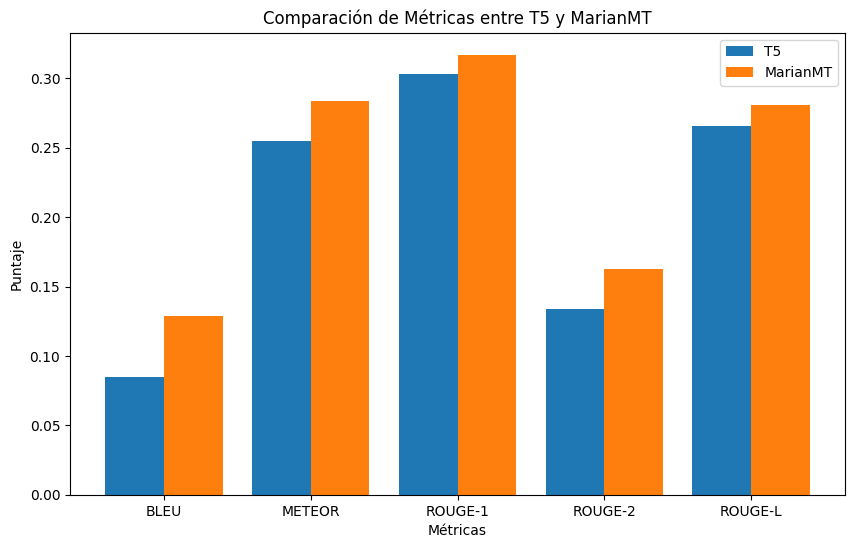

In [127]:
import matplotlib.pyplot as plt

scores_t5 = {
    "BLEU": bleu_t5['bleu'],
    "METEOR": meteor_t5["meteor"],
    "ROUGE-1": rouge_t5["rouge1"],
    "ROUGE-2": rouge_t5["rouge2"],
    "ROUGE-L": rouge_t5["rougeL"]
}

scores_marian = {
    "BLEU": bleu_marian["bleu"],
    "METEOR": meteor_marian["meteor"],
    "ROUGE-1": rouge_marian["rouge1"],
    "ROUGE-2": rouge_marian["rouge2"],
    "ROUGE-L": rouge_marian["rougeL"],
}

# Crear gráfico
labels = list(scores_t5.keys())
t5_values = list(scores_t5.values())
marian_values = list(scores_marian.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, t5_values, width=0.4, label="T5", align="center")
plt.bar([i + 0.4 for i in x], marian_values, width=0.4, label="MarianMT", align="center")

# Configurar etiquetas y leyenda
plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Métricas")
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas entre T5 y MarianMT")
plt.legend()

Como se puede observar los resultados no son muy buenos, esto se debe a la naturaleza juridica del dataset que estamos usando. Veamos un ejemplo en particular:

In [128]:
expected_output = "Su Señoría, si así lo desea, podrá plantear esta cuestión en ese momento, es decir, el jueves antes de que se presente el informe."
text = "That is precisely the time when you may, if you wish, raise this question, i.e. on Thursday prior to the start of the presentation of the report."
print("Oringinal text: ", text)
print("Marian translation: ", mariam_mt.translate(text))
print("T5 translation: ", t5_mt.translate(text))
print("Expected: ", expected_output)

Oringinal text:  That is precisely the time when you may, if you wish, raise this question, i.e. on Thursday prior to the start of the presentation of the report.
Marian translation:  Es precisamente el momento en que, si lo desea, puede plantear esta cuestión, es decir, el jueves antes del comienzo de la presentación del informe.
T5 translation:  Es precisamente cuando usted puede, si lo desea, formular esta pregunta, es decir, el jueves antes del comienzo de la presentación del informe.
Expected:  Su Señoría, si así lo desea, podrá plantear esta cuestión en ese momento, es decir, el jueves antes de que se presente el informe.
